# Wstępna analiza IUM
Rafał Bosko <br>

In [3]:
import jsonlines
import json
import pandas as pd
import math
import matplotlib.pyplot as plt

## Problem biznesowy
<blockquote>
Predykcja czy dana sesja użytkownika zakończy się zakupem na podstawie danych sesji. Skuteczna klasyfikacja sesji, które zakończą się zakupem umożliwi konsultantom szybsze rozwiązywanie problemów
</blockquote>

## Biznesowe kryterium sukcesu
System powinien przewidywać sesje, które zakończą się zakupem z efektywnością porównywalną z innymi istniejącymi rozwiązaniami wymienionymi w [literaturze](#Literatura). Dostarczenie takiej informacji pozwoli nie tylko na szybsze rozwiązywanie problemów, ale i zidentyfikowanie m.in. trendów sprzedażowych.

## Zadanie modelowania
Zadaniem jest klasyfikacja binarna odpowiadająca na pytanie "Czy sesja użytkownika zakończy się zakupem?".

Zmienną celu natomiast będzie liczbowa miara jakości generowanych predykcji dla wciąż trwających sesji, zdefiniowana jako *Accuracy* w sekcji poświęconej kryteriom sukcesu.

Do dyspozycji mamy historyczne dane składające się z:
* bazy użytkowników
* katalogu produktów
* historia sesji
* dane dotyczące wysyłki zakupionych produktów

Analiza tych danych historycznych, przydatnych do zbudowania modelu generującego predykcje znajduje się w sekcji o analizie zbioru danych.

## Analityczne kryterium sukcesu
Uzyskanie odpowiednio wysokiej skuteczności predykcji zapewnia miara *Accuracy* obliczana jako: 
$\frac{TP + TN}{TP + TN + FP + FN}$

Rozważaliśmy również *F1 score*, obliczanej jako: $2 * \frac{Precision * Recall}{Precision + Recall}$ gdzie: <br>
$Precision = \frac{TP}{TP + FP}$ oraz $Recall = \frac{TP}{TP + FN}$

Nie zdecydowaliśmy jednak wstępnie na tą miarę, ponieważ:
* jest trudniejsza do interpretacji
* F1 sprawdza się lepiej od Accuraccy w przypadku, gdy jest duża dysproporcja między klasami, a w naszym przypadku takiego problemu nie ma

## Analiza zbioru danych
Wstępna analiza danych pozwoliła nam odrzucić dane o przesyłkach, ponieważ te dane są dostarczane po zakupie i nie wpływają na zakup, podobna sytuacja dotyyczyła dwóch kolumn z tabeli sessions: typ zdarzenia i id zakupu, ponieważ to warość typu zdarzenia (zakup czy nie) będziemy przewidywali, a id zakupu jest ściśle skorelowane z typem zdarzenia.

Informacje zawarte w pozostałych tabelach są dostępne w trakcie trwania sesji, więc przeszliśmy do bardziej szczegółowej analizy tego fragmentu danych.

Postanowiliśmy wyróżnić ze zbioru danych następujące informacje:
* [*user_id*](#userId) - identyfikator użytkownika
* [*purchase*](#purchase) - wartość boolowska odpowiadająca na pytanie czy sesja zakończyła się zakupem
* [*offered_discount*](#discount) - wysokość zniżki
* [*item_views*](#item_views) - liczba obejrzanych przedmiotów w danej sesji
* [*unique_item_views*](#unique_item_views) - liczba przejrzanych unikalnych przedmiotów
* [*unique_categories*](#unique_categories) - liczba przejrzanych unikalnych kategorii

## Brakujące bądź niepoprawne wartości
Kontynuowaliśmy analizę danych, sprawdzając czy dane są poprawne, oraz czy wszystkie informacje są ze sobą powiązane w prawidłowy sposób. W wypadku niemożliwych do usunięcia błędów wartości, wskazanym będzie prośba do dostawcy danych o ich poprawienie.


In [37]:
def getDataFromJson(fileName):
    with open('../data/raw/'+fileName) as f:
        lines = f.read().splitlines()
    
    dataFrame = pd.DataFrame(lines)
    dataFrame.columns = ['json_element']
    return pd.json_normalize(dataFrame['json_element'].apply(json.loads))

### Analiza poprawności danych - sesje
Dane sesji w większości wypadków nie posiadają braków - tylko w kolumnie *purchase_id* występują wartości puste. Kolumna ta jednak sygnalizuje, że brak zakupu produktu oznaczany jest wartością null. Wartość ta zawsze znajduje się wspólnie z wartością VIEW_PRODUCT w kolumnie *event_type*, więc można założyć, że dane te są poprawne.

Ważnym jest jednak sprawdzenie pomyślnego połączenia danych sesji z danymi użytkownika. Zostało to wykonane w analizie poprawności danych użytkownika. 

In [41]:
sessionsDataFrame = getDataFromJson('sessions.jsonl')
sessionsDataFrame.info()

sessionsDataFrame["event_type"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37003 entries, 0 to 37002
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   session_id        37003 non-null  int64  
 1   timestamp         37003 non-null  object 
 2   user_id           37003 non-null  int64  
 3   product_id        37003 non-null  int64  
 4   event_type        37003 non-null  object 
 5   offered_discount  37003 non-null  int64  
 6   purchase_id       5686 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 2.0+ MB


count            37003
unique               2
top       VIEW_PRODUCT
freq             31317
Name: event_type, dtype: object

### Analiza poprawności danych - użytkownicy
Dane użytkowników nie posiadają żadnych braków.

Dokonane zostało sprawdzenie, czy wszystkie *user_id* z tabeli danych sesji pokrywają się z *user_id* z tabeli użytkownika, by nie pominąć przypadku, gdy w kolumnie *user_id* wpisany jets niepoprawny użytkownik. Sprawdzenie to poszło pomyślnie.

In [43]:
usersDataFrame = getDataFromJson('users.jsonl')
usersDataFrame.head()

,user_id,name,city,street
0,102,Mariusz Czerniec,Wrocław,pl. Północna 59/33
1,103,Adrianna Luberda,Poznań,ulica Szpitalna 80/66
2,104,Sylwia Adrian,Gdynia,plac Wyszyńskiego 774
3,105,Julianna Milej,Poznań,al. Podleśna 75/81
4,106,Ada Fiołka,Warszawa,plac Jagiellońska 432


In [47]:
usersDataFrame.info()

with open("../data/raw/users.jsonl") as file:
  lines = [n.strip() for n in file.readlines()]
  user_raw_data = [json.loads(n) for n in lines]
    
with open("../data/raw/sessions.jsonl") as file:
  lines = [n.strip() for n in file.readlines()]
  session_raw_data = [json.loads(n) for n in lines]

user_data_ids = set(user['user_id'] for user in user_raw_data)
for session in session_raw_data:
    assert session['user_id'] in user_data_ids

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  200 non-null    int64 
 1   name     200 non-null    object
 2   city     200 non-null    object
 3   street   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


### Analiza poprawności danych - produkty
Dane użytkowników nie posiadają żadnych braków.

Dokonane zostało sprawdzenie, czy wszystkie *product_id* z tabeli danych sesji pokrywają się z *product_id* z tabeli produktów, by nie pominąć przypadku, gdy w kolumnie *product_id* wpisany jets niepoprawny produkt. Sprawdzenie to poszło pomyślnie.

In [48]:
productsDataFrame = getDataFromJson('products.jsonl')
productsDataFrame.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


In [50]:
productsDataFrame.info()
productsDataFrame["price"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


count     319.000000
mean      247.787962
std       813.788548
min         1.000000
25%        24.990000
50%        41.000000
75%        92.995000
max      7639.000000
Name: price, dtype: float64

In [51]:
with open("../data/raw/products.jsonl") as file:
  lines = [n.strip() for n in file.readlines()]
  product_raw_data = [json.loads(n) for n in lines]
    
product_data_ids = set(product['product_id'] for product in product_raw_data)
for session in session_raw_data:
    assert session['product_id'] in product_data_ids

## Przykładowe rekordy

In [15]:
# sessions = pd.read_csv("../data/processed/merged_dataset", sep=' ')
# sessions.head()
   
sessionsDataFrame = getDataFromJson('sessions.jsonl')
sessionsDataFrame.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-05-26T01:18:01,102,1277,VIEW_PRODUCT,20,NaN
1,124,2021-05-26T01:19:32,102,1276,VIEW_PRODUCT,20,NaN
2,125,2021-07-16T14:16:04,102,1002,VIEW_PRODUCT,20,NaN
3,125,2021-07-16T14:17:23,102,1079,VIEW_PRODUCT,20,NaN
4,125,2021-07-16T14:19:23,102,1080,VIEW_PRODUCT,20,NaN


## Analiza ilościowa
Postanowiliśmy zbadać czy zbiór danych nie jest zdominowany przez sesje określonego typu: czy jest podobna
ilość tych które się zakończyły zakupem i tych w których do zakupu nie doszło:

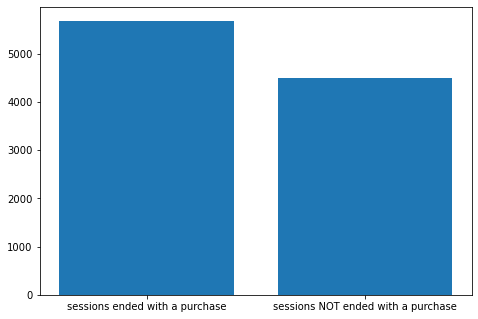

Różnica:  11.78%


In [6]:
sessionEndShopping = 0
sessionEndNotShopping = 0
sessionsDataFrame.sort_values(by=['session_id'])
sessions = []

for index, row in sessionsDataFrame.iterrows(): #merge session logs by id
    if len(sessions)==0:
        sessions.append([row['session_id'], row['event_type']])
    else:
        if sessions[len(sessions)-1][0] == row['session_id']:
            if sessions[len(sessions)-1][1] != 'BUY_PRODUCT':
                sessions[len(sessions)-1][1] = row['event_type']
        else:
            sessions.append([row['session_id'], row['event_type']])
   
for session in sessions:
    if session[1] == 'BUY_PRODUCT':
        sessionEndShopping += 1
    else:
        sessionEndNotShopping += 1
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['sessions ended with a purchase', 'sessions NOT ended with a purchase']
students = [sessionEndShopping,sessionEndNotShopping]
ax.bar(langs,students)
plt.show()

diff = abs(sessionEndNotShopping-sessionEndShopping)/(sessionEndShopping+sessionEndNotShopping)
print('Różnica:  '+str(round(diff*100, 2))+'%')


Okazuje się że sesji zakończonych zakupem jest nieco więcej, niż tych w których do zakupu nie doszło. Nie istnieje jednak tutaj problem wynikający z niezbalansowania danych - różnica między sesjami zakończonymi zakupem a sesjami niezakończonymi nie jest wystarczająco duża.

Postanowiliśmy sprawdzić ile unikalnych kategorii produktów mamy i jak się mają ich rozkłady.

In [7]:
def checkIfUnique(collection, name):
    for element in collection:
        if element[0] == name:
            return False
    return True;

def getSubCategories(collection, name):
    for element in collection:
        if element[0] == name:
            element[2] += 1
            return element[1]
    return None

def addCategories(collection, categoryArray, depth):
    if len(categoryArray) > depth:
        category = categoryArray[depth]
        if checkIfUnique(collection, category):
            collection.append([category,[],0])
        subCategories = getSubCategories(collection, category)
        addCategories(subCategories, categoryArray, depth+1)
        
def printCollection1(collection, string):
    if len(collection) == 0:
        print(string[2:])
    else:
        for element in collection:
            printCollection1(element[1], string+': '+element[0]+'('+str(element[2]) +')')
        
def printCollection2(collection, length):
    for element in collection:
        print(element[0]+':  ',end = '')
        printCollection2(element[1], length+len(element[0]))

Z poniżej wyznaczonych kategorii produktów wynika, że znaczącą większość produktów w sklepie stanowią "Gry i konsole", a w nich przeważającym składnikiem są "Gry komputerowe". Są to dane niezbalansowane, wynikające ze specjalizacją sklepu, dla którego szykujemy biznesowe rozwiązanie predykcyjne.

In [8]:
sessionsDataFrame = getDataFromJson('products.jsonl')

mainCategories = []

for index, row in sessionsDataFrame.iterrows():
    categories = row['category_path'].split(';')
    addCategories(mainCategories, categories, 0)
    
printCollection1(mainCategories,'')


Telefony i akcesoria(12): Telefony stacjonarne(1)
Telefony i akcesoria(12): Telefony komórkowe(2)
Telefony i akcesoria(12): Akcesoria telefoniczne(9): Zestawy głośnomówiące(5)
Telefony i akcesoria(12): Akcesoria telefoniczne(9): Zestawy słuchawkowe(4)
Komputery(28): Drukarki i skanery(9): Biurowe urządzenia wielofunkcyjne(9)
Komputery(28): Monitory(17): Monitory LCD(17)
Komputery(28): Tablety i akcesoria(2): Tablety(2)
Gry i konsole(243): Gry na konsole(41): Gry Xbox 360(32)
Gry i konsole(243): Gry na konsole(41): Gry PlayStation3(9)
Gry i konsole(243): Gry komputerowe(202)
Sprzęt RTV(36): Video(33): Odtwarzacze DVD(2)
Sprzęt RTV(36): Video(33): Telewizory i akcesoria(31): Okulary 3D(1)
Sprzęt RTV(36): Video(33): Telewizory i akcesoria(31): Anteny RTV(30)
Sprzęt RTV(36): Przenośne audio i video(2): Odtwarzacze mp3 i mp4(2)
Sprzęt RTV(36): Audio(1): Słuchawki(1)


## Literatura

* Esmeli, R., Bader-El-Den, M. & Abdullahi, H. Towards early purchase intention prediction in online session based retailing systems. Electron Markets 31, 697–715 (2021). https://doi.org/10.1007/s12525-020-00448-x
* S. Luo, S. Zhang and H. Cong, "Research on Consumer Purchasing Prediction Based on XGBoost Algorithm," 2021 IEEE International Conference on Artificial Intelligence and Computer Applications (ICAICA), 2021, pp. 1173-1176. https://doi.org/10.1109/ICAICA52286.2021.9497944
* Bruno J.D. Jacobs, Bas Donkers, Dennis Fok (2016) Model-Based Purchase Predictions for Large Assortments. Marketing Science 35(3):389-404. https://doi.org/10.1287/mksc.2016.0985
* Haubner, Nicolas & Setzer, Thomas. (2021). Hybrid Recommender Systems for Next Purchase Prediction Based on Optimal Combination Weights.
[Źródło](https://www.researchgate.net/publication/349711825_Hybrid_Recommender_Systems_for_Next_Purchase_Prediction_Based_on_Optimal_Combination_Weights)